In [1]:
import numpy as np
import scipy.spatial
import scipy.io
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

import viscosity
import continuation
import skimming

In [2]:
def map_colors(vec, left, right):
    n = len(vec)
    left = np.array(left)
    right = np.array(right)
    c = [list(left + (right-left)/n*i) for i in range(n)]
    return [c[int(i)] for i in np.argsort(vec)]

In [3]:
class NetworkSkeleton:
    def __init__(self):
        pass
    
    def get(self):
        return {'v':self.v, 'e':self.e, 'l':self.l, 'd':self.d, 'w':self.w}
    
class PeriodicNetworkSkeleton(NetworkSkeleton): 
    def __init__(self,points,x_min,x_max,y_min,y_max):
        # create fake points to the left and the right in order to do periodic wrap
        offset_x = (x_max-x_min)
        w = np.array([points[:,0] - offset_x, points[:,1]]).T
        e = np.array([points[:,0] + offset_x, points[:,1]]).T
        points = np.concatenate([points,w,e])  

        # let scipy.spatial do the heavy lifting
        from scipy.spatial import Voronoi, voronoi_plot_2d
        vor = Voronoi(points)
        
        # initialize the three main return data structure
        vertices = np.copy(vor.vertices) 
        edges = []
        wrap = []


        new_vert_idx = len(vor.vertices)
        for ridge in vor.ridge_vertices:
            wrapFlag = False
            # -1 represents point at infinity 
            if -1 in ridge:
                continue

            # ridge has format [[x0,y0],[x1,y1]]; pull these (we'll need i0 and i1 later)
            i0 = ridge[0]
            x0 = vor.vertices[i0,0]
            y0 = vor.vertices[i0,1]

            i1 = ridge[1]
            x1 = vor.vertices[i1,0]
            y1 = vor.vertices[i1,1]    

            # booleans for whether each point is inside the domain of interest
            vt0_inside = (x_min <= x0 <= x_max) & (y_min <= y0 <= y_max)
            vt1_inside = (x_min <= x1 <= x_max) & (y_min <= y1 <= y_max)

            if not vt0_inside and not vt1_inside:
                continue
            if vt0_inside and not vt1_inside:
                # for points in the bottom right or bottom left, two of these can be activated
                if x1 > x_max and y1 < y_max:
                    d = [(vor.vertices[i,0] + offset_x - x1)**2 + (vor.vertices[i,1] - y1)**2 for i in range(len(vor.vertices))]
                    i1 = np.argmin(d)
                    if y1 > y_min:
                        wrapFlag = True
                if x1 < x_min and y1 < y_max:
                    d = [(vor.vertices[i,0] - offset_x - x1)**2 + (vor.vertices[i,1] - y1)**2 for i in range(len(vor.vertices))]
                    i1 = np.argmin(d)
                    if y1 > y_min: 
                        wrapFlag = True
                if y1 > y_max:
                    slope = (y1-y0)/(x1-x0)
                    x1_hat = (y_max - y0)/slope + x0
                    y1_hat = y_max

                    i1 = new_vert_idx
                    new_vert_idx += 1

                    vertices = np.concatenate([vertices,np.matrix([x1_hat,y1_hat])])
                if y1 < y_min:
                    slope = (y1-y0)/(x1-x0)
                    x1_hat = (y_min - y0)/slope + x0
                    y1_hat = y_min            

                    i1 = new_vert_idx
                    new_vert_idx += 1

                    vertices = np.concatenate([vertices,np.matrix([x1_hat,y1_hat])])            
            elif not vt0_inside and vt1_inside:
                if x0 > x_max and y0 < y_max:
                    d = [(vor.vertices[i,0] + offset_x - x0)**2 + (vor.vertices[i,1]-y0)**2 for i in range(len(vor.vertices))]
                    i0 = np.argmin(d)
                    if y0 > y_min:
                        wrapFlag = True                
                if x0 < x_min and y0 < y_max:
                    d = [(vor.vertices[i,0] - offset_x - x0)**2 + (vor.vertices[i,1]-y0)**2 for i in range(len(vor.vertices))]
                    i0 = np.argmin(d)
                    if y0 > y_min:
                        wrapFlag = True                
                if y0 > y_max:
                    slope = (y1-y0)/(x1-x0)
                    x0_hat = (y_max - y1)/slope + x1
                    y0_hat = y_max

                    i0 = new_vert_idx
                    new_vert_idx += 1

                    vertices = np.concatenate([vertices,np.matrix([x0_hat,y0_hat])])
                if y0 < y_min:
                    slope = (y1-y0)/(x1-x0)
                    x0_hat = (y_min - y1)/slope + x1
                    y0_hat = y_min            

                    i0 = new_vert_idx
                    new_vert_idx += 1

                    vertices = np.concatenate([vertices,np.matrix([x0_hat,y0_hat])])

            if [i0,i1] in edges or [i1, i0] in edges:
                continue

            edges.append([i0,i1])
            wrap.append(wrapFlag)
        wrap = np.array(wrap)
        
        self.v = vertices
        self.e = edges
        self.l = None
        self.d = None
        self.w = wrap
    
    def reduce_vertex_labels(self):
        vertices_idxs = (list(set([vertex for edge in self.e for vertex in edge])))
        vertices_idxs.sort()
        
        mapping = {}
        new_vertices = []
        for i,vertex_idx in enumerate(vertices_idxs):
            new_vertices.append(self.v[vertex_idx,:])
            mapping[vertex_idx] = i

        vertices = np.concatenate(new_vertices)
        edges = [[mapping[i],mapping[j]] for [i,j] in self.e]    

        self.v = vertices
        self.e = edges
    
    def reorder_vertex_labels(self):
        # reorder by y-coordinate for readability
        order = np.argsort(self.v[:,1].T).tolist()[0][::-1]
        mapping = {} 
        for i,v in enumerate(order):
            mapping[v] = i

        vertices = self.v[order,:]
        edges = [[mapping[i],mapping[j]] for [i,j] in self.e]

        self.v = vertices
        self.e = edges        
    
class PeriodicHoneycombSkeleton(PeriodicNetworkSkeleton):
    def __init__(self,m,n,pert,seed=None):
        self.seed = seed
        
        points = []
        for j in range(m):
            points += [(j,(i*2*np.sin(np.pi/3)+(j%2)*np.sin(np.pi/3))*2/3) for i in range(n)]

        if self.seed:
            np.random.seed(self.seed)
            
        points = np.array(points)
        points += np.random.random(np.shape(points))*pert
        points = np.array(points)
    
        N = ((n-1)*2*np.sin(np.pi/3)+np.sin(np.pi/3))*2/3
        
        super(PeriodicHoneycombSkeleton,self).__init__(points,0,m,0,N)
        
        super(PeriodicHoneycombSkeleton,self).reduce_vertex_labels()
        super(PeriodicHoneycombSkeleton,self).reorder_vertex_labels()
        
        l = np.zeros(len(self.e))
        for i in range(len(self.e)):
            v0 = self.v[self.e[i][0],:]
            v1 = self.v[self.e[i][1],:]
            if not self.w[i]:
                l[i] = np.sqrt((v0[0,0]-v1[0,0])**2 + (v0[0,1]-v1[0,1])**2)
            else:
                if v1[0,0] > v0[0,0]:
                    l[i] = np.sqrt((v0[0,0]-(v1[0,0]-m))**2 + (v0[0,1]-v1[0,1])**2)
                else:
                    l[i] = np.sqrt((v0[0,0]-m-v1[0,0])**2 + (v0[0,1]-v1[0,1])**2)
        if self.seed:
            np.random.seed(self.seed)    
        d = np.ones(len(self.e)) + (np.random.random(len(self.e)) - .5)/.5*.1

        self.l = l
        self.d = d

class LadderNetworkSkeleton(NetworkSkeleton):
    def __init__(self,n):
        v = np.zeros((2*n+4,2))

        for i in range(n+2):
            v[2*i,:] = [0,n+1-i]
            v[2*i+1,:] = [1,n+1-i]

        e = []
        for i in range(n):
            e.append([2*i,2*i+2])
            e.append([2*i+1,2*i+3])
            e.append([2*i+2,2*i+3])

        e.append([2*n,2*n+2])
        e.append([2*n+1,2*n+3])

        l = np.ones(len(e))
        d = np.ones(len(e))

        w = len(e)*[False]

        self.v = v
        self.e = e
        self.l = l
        self.d = d
        self.w = w  

class RepeatedLadderSkeleton(NetworkSkeleton):
    def __init__(self,m,n):
        v = []
        e = []
        w = []
        for i in range((2*m+2)*(n+1)):
            v.append([i%(n+1),m-i//(n+1)])

            if i <= n:
                e.append([i,i+n+1])
                w.append(False)
            elif i > n and i < (2*m+2)*(n+1) - (n+1):
                e.append([i,i+n+1])
                w.append(False)
                if (i//(n+1))%2 == 1:
                    if i%2 == 0:
                        e.append([i,i+1])
                        w.append(False)
                else: 
                    if i%2 == 1:
                        if i%(n+1) == (-1)%(n+1):
                            e.append([i,i-n])
                            w.append(True)
                        else:
                            e.append([i,i+1])
                            w.append(False)
            elif i >= (m+4)*(n+1) - (n+1):
                pass


        for i in range((2*m+2)*(n+1) - 2*(n+1), (2*m+2)*(n+1) - (n+1)):
            e.append([i,i+n+1])
            w.append(False)

        v = np.array(v).astype(float)

        l = np.ones(len(e))
        d = np.ones(len(e))
        
        self.v = v
        self.e = e
        self.l = l
        self.d = d
        self.w = w     
    
class CarrASkeleton(NetworkSkeleton):
    def __init__(self):
        e = [[0,1],[1,2],[1,3],[2,5],[2,12],[3,4],[3,6],[4,8],[4,12],[8,7],[8,9],[9,10],[9,13],[10,11],[10,12]]

        v = np.zeros((14,2))
        v[0,:] = [0,1]
        v[1,:] = [1,1]
        v[2,:] = [1,0]
        v[3,:] = [1.5,1]
        v[4,:] = [2,1]
        v[5,:] = [0,0]
        v[6,:] = [1.5,1.5]
        v[7,:] = [4,1]
        v[8,:] = [3,1]
        v[9,:] = [3,0.5]
        v[10,:] = [3,0]
        v[11,:] = [4,0]
        v[12,:] = [2,0]
        v[13,:] = [4,0.5]

        l = np.array([164.7, 164.7, 23.5, 188.2, 447.1, 164.7, 494.1, 282.4, 211.8, 564.7, 211.8, 47.1, 164.7, 235.3, 235.3])
        d = np.array([11.6, 11.6, 9.1, 12.8, 5.9, 8.7, 7.9, 8.0, 5.3, 18.1, 12.5, 11.9, 5.1, 10.8, 5.7])

        w = [False]*len(e)
        
        self.v = e
        self.e = e
        self.l = l
        self.d = d
        self.w = w         
              
class Network:
    def __init__(self,params):
        for key in params:
            setattr(self, key, params[key])
            
        self.params = params
            
        self.construct_adj_inc()
        self.construct_boundary_conditions()
        self.construct_relation_matrix()
        self.construct_initial_state()
        
        self.equilibria = []
    
    ### Initliazation methods
    def construct_adj_inc(self):
        n_v = len(self.v)
        n_e = len(self.e)
        adj = np.zeros((n_v,n_v))
        inc = np.zeros((n_v,n_e))

        for i,edge in enumerate(self.e):
            e0 = edge[0]
            e1 = edge[1]

            adj[e0,e1] = 1
            adj[e1,e0] = 1

            inc[e0,i] = 1
            inc[e1,i] = 1
            
        self.adj = adj
        self.inc = inc
        
        self.nNodes = int(adj.shape[0])
        self.nVessels = int(inc.shape[1])

        self.interiorNodes = np.where(np.sum(adj,axis=0) == 3)[0]
        self.exteriorNodes = np.where(np.sum(adj,axis=0) == 1)[0]
        self.exteriorFlows = np.where(np.sum(inc[self.exteriorNodes,:],axis=0) == 1)[0]        
        
    def construct_relation_matrix(self):
        n = self.nVessels + len(self.interiorNodes)

        mat = np.zeros((n,n))
        rhs = np.zeros(n)
        for i in range(self.nVessels):
            nodIdx = np.arange(self.nNodes)[self.inc[:,i] == 1]
            if nodIdx[0] in self.exteriorNodes:
                rhs[i] = self.pext[nodIdx[0]]
                b = np.where(self.interiorNodes == nodIdx[1])[0]
                mat[i,self.nVessels+b] = 1
            elif nodIdx[1] in self.exteriorNodes:
                rhs[i] = -self.pext[nodIdx[1]]
                b = np.where(self.interiorNodes == nodIdx[0])[0]
                mat[i,self.nVessels+b] = -1
            else:
                b = np.where(self.interiorNodes == nodIdx[0])[0]
                c = np.where(self.interiorNodes == nodIdx[1])[0]

                mat[i,self.nVessels+b] = -1
                mat[i,self.nVessels+c] = 1

        for i in range(len(self.interiorNodes)):
            j = self.interiorNodes[i]
            nodIdx = np.where(self.adj[j,:] == 1)[0]
            vesIdx = len(nodIdx)*[0]
            for k in range(len(nodIdx)):
                vesIdx[k] = np.where(np.logical_and(self.inc[j,:] == 1,self.inc[nodIdx[k],:] == 1))[0]
                if j > nodIdx[k]: mat[self.nVessels+i,vesIdx[k]] = 1
                else:
                    mat[self.nVessels+i,vesIdx[k]] = -1

        self.relMat = mat
        self.relRHS = rhs   

    def construct_boundary_conditions(self):
        hin = np.zeros(self.nNodes)
        hin[self.exteriorNodes] = self.hin
        self.hin = hin
        
        self.pext = np.squeeze(np.array(self.v[:,1].copy()))/np.max(np.array(self.v[:,1]))
#         self.pext += np.random.random(self.pext.shape)*.1
        self.pext[self.interiorNodes] = 0        
        
    def construct_initial_state(self):
        self.h = np.random.random(self.nVessels)
        r = self.l/self.d**4*viscosity.viscosity_arrhenius(self.h,self.delta)

        mat = self.relMat.copy()
        for i in range(self.nVessels):
            mat[i,i] = r[i]
        self.state = np.linalg.solve(mat,self.relRHS)
        
    ### Physics 'n stuff 
    def hematocrits(self):
        q = self.state[:self.nVessels]
        p = self.pext
        p[self.interiorNodes] = self.state[self.nVessels:]

        sortIdx = np.argsort(p)[::-1]

        h = np.nan*np.ones(np.shape(q))
        for j in range(self.nNodes):
            j = sortIdx[j]
            nodIdx = np.arange(self.nNodes)[self.adj[j,:] == 1]
            vesIdx = np.array([0]*len(nodIdx))
            for k in range(len(nodIdx)):
                vesIdx[k] = int(np.where(np.logical_and(self.inc[j,:] == 1, self.inc[nodIdx[k],:] == 1))[0])
            inflow = p[nodIdx] > p[j]
            outflow = inflow == False

            if len(nodIdx) == 1:
                if outflow:
                    node = 'ExtIn'
                    h[vesIdx[0]] = self.hin[j]
                else:
                    node = 'ExtOut'
            else:
                inflowIdx = list(vesIdx[inflow])
                outflowIdx = list(vesIdx[outflow])
                if len(inflowIdx) == 0 or len(outflowIdx) == 0:
                    self.h = np.nan*np.ones(np.shape(q))
                    return
                if len(outflowIdx) == 2:
                    node = 'Div'
                    hfeed = h[inflowIdx[0]]
                    qfeed = q[inflowIdx[0]]
                    qalpha = q[outflowIdx[0]]

                    (f,g) = skimming.skimming_kj(abs(qalpha/qfeed),self.pPlasma)

                    h[outflowIdx[0]] = hfeed*f
                    h[outflowIdx[1]] = hfeed*g
                    
                else:
                    node = 'Conv'
                    qa = abs(q[inflowIdx[0]])
                    ha = h[inflowIdx[0]]
                    qb = abs(q[inflowIdx[1]])
                    hb = h[inflowIdx[1]]
                    qo = abs(q[outflowIdx[0]])

                    h[outflowIdx[0]] = min((qa*ha + qb*hb)/qo,1)
                if max(h) > 1 or min(h) < 0:
                    self.h = np.nan*np.ones(np.shape(q))
                    return
        self.h = h  
    
    ### Equilibria Methods
    def equilibrium_relation(self,x):
        self.state = x
        self.hematocrits()
        r = self.l/self.d**4*viscosity.viscosity_arrhenius(self.h,self.delta)
    
        mat = self.relMat.copy()
        for i in range(self.nVessels):
            mat[i,i] = r[i]

        out = np.linalg.solve(mat,self.relRHS) - self.state              
        return out
                
    def find_equilibria(self,n,verbose=False,tol=1e-5):
        if self.seed: np.random.seed(self.seed)
        self.equilibria = []
        i = 0 
        while i < n:
            self.construct_initial_state()
            self.state = fsolve(self.equilibrium_relation,self.state)
            
            deviation = np.linalg.norm(self.equilibrium_relation(self.state))/len(self.state)
            
            if np.isnan(deviation):
                continue
            
            if deviation > tol:
                continue
            
            if verbose:
                print(f'{i+1}: |F(x*)| = {np.round(deviation,6)}')
            if i == 0:
                self.equilibria = self.state.reshape(-1,1)
            else:
                self.equilibria = np.concatenate((self.equilibria,self.state.reshape(-1,1)),axis=1)
            i += 1
 
    ### TTD methods
    def compute_conditional_probabilities_downstream(self):
        self.hematocrits()
        q = self.state[:self.nVessels]
        self._rbc = self.h*np.abs(q)     

        p = self.pext
        p[self.interiorNodes] = self.state[self.nVessels:]

        rbc_normalizer = np.zeros(self._rbc.shape)
        sortIdx = np.argsort(p)[::-1]
        for j in range(self.nNodes):
            j = sortIdx[j]
            nodIdx = np.arange(self.nNodes)[self.adj[j,:] == 1]
            vesIdx = np.array([0]*len(nodIdx))
            for k in range(len(nodIdx)):
                vesIdx[k] = int(np.where(np.logical_and(self.inc[j,:] == 1, self.inc[nodIdx[k],:] == 1))[0])
            inflow = p[nodIdx] > p[j]
            outflow = inflow == False

            
            outflows = self.get_outflows()
            if len(nodIdx) == 1:
                if outflow:
                    rbc_normalizer[vesIdx[0]] = np.sum(self._rbc[self.exteriorFlows])/2 #    
                else:
                    pass
            else:
                inflowIdx = list(vesIdx[inflow])
                outflowIdx = list(vesIdx[outflow])

                # Diverging Node
                if len(outflowIdx) == 2:
                    rbc_normalizer[outflowIdx[0]] = self._rbc[inflowIdx[0]]
                    rbc_normalizer[outflowIdx[1]] = self._rbc[inflowIdx[0]]                  
                # Converging Node
                else:
                    rbc_normalizer[outflowIdx[0]] = self._rbc[outflowIdx[0]]

        self._cond_prob = self._rbc/rbc_normalizer
    
    def directed_adj_dict(self):
        q = self.state[:self.nVessels]
        A = {}
        for i in range(len(q)):
            v0 = min(self.e[i])
            v1 = max(self.e[i])
            if q[i] > 0:
                A[v0] = A.get(v0,[]) + [v1]
            else:
                A[v1] = A.get(v1,[]) + [v0]

        for key,item in A.items():
            A[key] = set(item)

        for i in set(range(int(self.adj.shape[0]))) - set(A.keys()):
            A[i] = set([])

        self._adj_dict = A
     
    def get_paths_by_node_from_inlet(self,inlet):
        stack = [(inlet,[inlet])]
        paths = []
        while stack:
            (vertex, path) = stack.pop()

            if len(self._adj_dict[vertex]) == 0:
                paths.append(path)
            for next in self._adj_dict[vertex] - set(path):
                stack.append((next, path + [next]))            
    
        return paths
       
    def get_paths_by_node(self):
        self.directed_adj_dict()
        paths = []
        for i in self.exteriorNodes:
            new = self.get_paths_by_node_from_inlet(i)
            if len(new[0]) == 1:
                continue
            paths += new   
        self._paths_by_node = paths
    
    def get_paths_by_edge(self):
        self.get_paths_by_node()
        self._paths_by_edge = [[self.inc[[path[i],path[i+1]],:].sum(axis=0).argmax() for i in range(len(path)-1)] for path in self._paths_by_node]        
    
    def get_outflows(self):
        p = self.pext
        p[self.interiorNodes] = self.state[self.nVessels:]
        self._outflows = [self.inc[ext,:].nonzero()[0][0] for ext in self.exteriorNodes if (p[self.adj[:,ext].nonzero()][0] - p[ext]) > 0]    
    
    def compute_ttd(self,verbose=False):
        q = self.state[:self.nVessels]
        p = self.pext
        p[self.interiorNodes] = self.state[self.nVessels:]    

        self.compute_conditional_probabilities_downstream()
        if verbose:
            print(f'Cond prob: {self._cond_prob}')
        
        self.get_paths_by_edge()
        
        probs = []
        for path in self._paths_by_edge:
            probs.append(np.product(self._cond_prob[path]))

        if verbose: 
            for i,prob in enumerate(probs):
                print(f'P(RBC -> {self._paths_by_edge[i]}) \t= {np.round(prob,6)}')
            print(f'Check sum of total probability : {np.sum(probs)}')

        vol = np.pi*(self.d/2)**2*self.l
        tau = vol/np.abs(q)

        delays = []
        for path in self._paths_by_edge:
            delays.append(np.sum(tau[path]))

        if verbose: 
            for i,delay in enumerate(delays):
                print(f'{self._paths_by_edge[i]} :\t {delay}')
                
        ttd = TransitTimeDistribution(self._paths_by_edge, delays, probs)
#         if np.abs(np.sum(ttd.probs) - 1) > 1e-3:
#             print('Warning: Cumul. prob. of candidate TTD is not equal to 1!')
        self.ttd = ttd
    
    ### Plotting
    def plot(self,width=[],colors=[],directions=[],annotate=False,ms=10):
        x_min = np.min(self.v[:,0])-0.25
        x_max = np.max(self.v[:,0])+0.25
        y_min = np.min(self.v[:,1])-0.25
        y_max = np.max(self.v[:,1])+0.25
        if len(colors) == 0: colors = len(self.e)*['k']
        if len(width) == 0: width = len(self.e)*[1]
        for i,edge in enumerate(self.e):
            i0 = min([edge[0],edge[1]])
            i1 = max([edge[0],edge[1]])        

            x0 = self.v[i0,0]
            y0 = self.v[i0,1]

            x1 = self.v[i1,0]
            y1 = self.v[i1,1]

            if not self.w[i]:
                plt.plot([x0, x1], [y0,y1],'-', c=colors[i], lw=width[i])
            else:
                if x1 > x0:
                    plt.plot([x0, x1-(x_max-x_min)], [y0,y1], '-', c=colors[i], lw=width[i])
                    plt.plot([x0+(x_max-x_min), x1], [y0,y1], '-', c=colors[i], lw=width[i])
                else:
                    plt.plot([x0-(x_max-x_min), x1], [y0,y1], '-', c=colors[i], lw=width[i])
                    plt.plot([x0, x1+(x_max-x_min)], [y0,y1], '-', c=colors[i], lw=width[i])                
            if len(directions):
                if directions[i] == 1:
                    if len(self.w):
                        if self.w[i] == 0:
                            plt.arrow(x0,y0,(x1-x0)/2,(y1-y0)/2,head_width=.2,lw=0)                    
                elif directions[i] == -1:
                    if len(self.w):
                        if self.w[i] == 0:
                            plt.arrow(x1,y1,(x0-x1)/2,(y0-y1)/2,head_width=.2,lw=0)

            if annotate == True: 
                if self.w[i] == 0:
                    plt.annotate(str(i),(x0+(x1-x0)/2+0.05,y0+(y1-y0)/2),fontsize=16)
                else:
                    plt.annotate(str(i),(np.max((x0,x1))+.05,y1),fontsize=16,color='r')

        for node in range(len(self.v)):
            x = self.v[node,0]
            y = self.v[node,1]
            plt.plot(x,y ,'wo',mec='k',ms=ms)
            x,y = self.v[node,0], self.v[node, 1]
            if annotate:
                plt.text(x+0.02,y,str(node),fontsize=12)

        plt.gca().set_xticks([])
        plt.gca().set_yticks([])    

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)        

        plt.gca().set_aspect('equal')                
    
    ### General methods
    def save(self,prefix):
        scipy.io.savemat(f'data/{prefix}_eqs.mat',{'eqs':self.equilibria})
        f = open(f'data/{prefix}_params.p','wb')
        pickle.dump(self.params,f)
        f.close()
                      
    def info(self):
        print('Number of nodes: ' + str(self.nNodes))
        print('Number of vessels: ' + str(self.nVessels))
        print('Number of in/out-lets: ' + str(len(self.exteriorFlows)))         
        
class TransitTimeDistribution:
    def __init__(self,paths,delays,probabilities):
        self.paths = paths
        self.delays = np.array(delays)
        self.probs = np.array(probabilities)
        
        self.compute_expected_delay()
        
    def compute_expected_delay(self):
        self.expected_delay = 0
        for i in range(len(self.delays)):
            self.expected_delay += self.probs[i]*self.delays[i]
            
    def plot(self,kind='pdf',normalizer=1,xlabel='Transit Time',alpha=0.25):
        taus = self.delays/normalizer

        if kind == 'pdf':  
            plt.loglog(taus,self.probs,'ko')
            plt.xlabel(xlabel)
            plt.ylabel('Probability []')
        elif kind == 'cdf':
            idx = np.argsort(taus)

            taus = taus[idx]
            probs = self.probs[idx]
            probs = np.cumsum(probs)

            plt.plot(taus,probs,'k-',alpha=alpha)
            plt.xlabel(xlabel)
            plt.ylabel('Cumul. Prob. []')            
                        
def load(prefix):
    eqs = scipy.io.loadmat(f'data/{prefix}_eqs.mat')['eqs']
    f = open(f'data/{prefix}_params.p','rb')
    params = pickle.load(f)
    f.close()
    
    out = Network(params)
    out.equilibria = eqs
    
    return out

In [4]:
seed = 1234

m = 4
n = m
pert = 0.3
S = PeriodicHoneycombSkeleton(m,n,pert,seed)

physParams = {'pPlasma':2, 'delta':3.5, 'hin':0.4, 'seed':seed}
params = {**S.get(), **physParams}

N = Network(params)

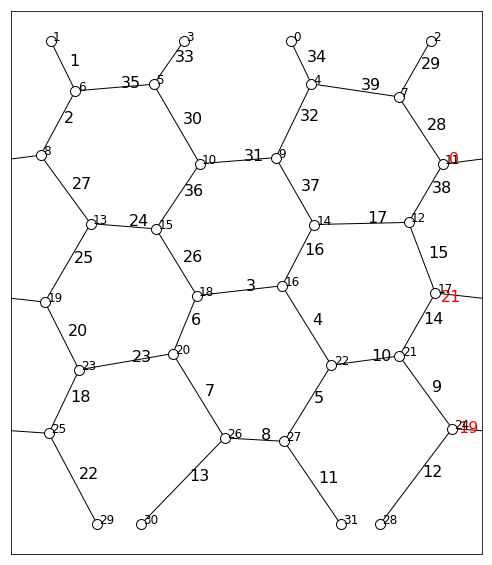

In [5]:
plt.figure(figsize=(10,10))
N.plot(annotate=True)

In [ ]:
neq = 10000
N.find_equilibria(n=neq,verbose=True,tol=1e-4)

In [7]:
N.save(f'nm_{n}_neq_{neq}')

# Manuscript Figures

In [20]:
class ManuscriptFigure:
    def __init__(self,network):
        self.network = network
        self._orig_state = network.state.copy()
        self._orig_h = network.h.copy()

    def restore_network_state(self):
        self.network.state = self._orig_state
        self.network.h = self._orig_state
        self.network.compute_ttd()
    
    def check_ttds(self):
        for i in range(self.network.equilibria.shape[1]):
            self.network.state = self.network.equilibria[:,i]
            self.network.hematocrits()
            self.network.compute_ttd()
            print(f'Eq {i}:')
            print(f'\tCum. prob. of TTD:{self.network.ttd.probs.sum()}')
            print(f'\tMax. H in net.:{self.network.h.max()}')    
        self.restore_network_state()
    
    def set_font_size(self,fs):
        ax = plt.gca()
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fs)        
    
    def despine(self):
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().set_aspect('equal')
    
    def cull_equilibria(self):
        Y = self.network.equilibria[:,0].reshape(-1,1)
        for i in range(self.network.equilibria.shape[1]-1):
            flag = True
            for j in range(Y.shape[1]):
                if np.sum(self.network.equilibria[:,i+1]*Y[:,j] < 0) == 0:
                    flag = False
            if not flag:
                continue
            Y = np.concatenate((Y,self.network.equilibria[:,i+1].reshape(-1,1)),axis=1)
        return Y  
    
    def plot(self):
        pass
    
    def save(self,filename):
        plt.savefig(f'figures/{filename}.pdf',bbox_inches='tight')
        
class TTDsCDFs(ManuscriptFigure):
    def __init__(self,network):
        super().__init__(network)
        
    def plot(self,cull=False,alpha=1,xlim=5,filename='ttds_cdfs'):
        if cull: 
            Y = self.cull_equilibria()
        else:
            Y = self.network.equilibria
            
        plt.figure()
        for i in range(Y.shape[1]):
            self.network.state = Y[:,i]
            self.network.compute_ttd()
            self.network.ttd.plot(kind='cdf',normalizer=self.network.ttd.expected_delay,alpha=alpha)
        plt.ylim((0,1))
        plt.xlim((0,xlim))
        self.save(filename)
        self.restore_network_state()

class TTDWithPaths(ManuscriptFigure):
    def __init__(self,network):
        super().__init__(network)
    
    def plot(self,eqIdx,normalizer=1):
        self.network.state = self.network.equilibria[:,eqIdx]
        self.network.compute_ttd()

        plt.figure(figsize=(10,5))
        plt.sca(plt.subplot(121))
        self.network.ttd.plot(kind='pdf')

        idx = np.argsort(self.network.ttd.delays)
        path_max = self.network.ttd.paths[idx[-1]]
        path_min = self.network.ttd.paths[idx[0]]
        plt.loglog(self.network.ttd.delays[idx[-1]]/normalizer,self.network.ttd.probs[idx[-1]],'bo')
        plt.loglog(self.network.ttd.delays[idx[0]]/normalizer,self.network.ttd.probs[idx[0]],'ro') 

        plt.sca(plt.subplot(122))
        colors = self.network.nVessels*['k']
        for i,edge in enumerate(path_max):
            colors[edge] = 'b'

        for i,edge in enumerate(path_min):
            colors[edge] = 'r'

        self.network.plot(directions=np.sign(self.network.state[:self.network.nVessels]),colors=colors)
        plt.gca().set_aspect('equal')

        self.save('ttd_with_paths')
        self.restore_network_state()
    
class JunctionSkimming(ManuscriptFigure):
    def __init__(self,network):
        super().__init__(network)
        
    def plot(self):
        plt.figure(figsize=(16,9))
        lw = 4
        fs = 20
        offset_x = .4
        plt.subplot(1,2,1)
        plt.plot([0,1],[0,0],'k',lw=lw)
        plt.plot([1,(1+1/np.sqrt(2))],[0,1*1/np.sqrt(2)],'k',lw=lw)
        plt.plot([1,1*(1+1/np.sqrt(2))],[0,1*-1/np.sqrt(2)],'k',lw=lw)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.annotate(r'$Q_F$, $H_F$',[0,.05],fontsize=fs)
        plt.annotate(r'$Q_A$, $H_A$',[1+np.sqrt(2)/2-offset_x,np.sqrt(2)/2],fontsize=fs)
        plt.annotate(r'$Q_B$, $H_B$',[1+np.sqrt(2)/2-offset_x,-np.sqrt(2)/2],fontsize=fs)
        plt.arrow(0,0,1/2,0,head_width=.1,lw=0,color='black')
        plt.arrow(1,0,1/np.sqrt(2)/2,-1/np.sqrt(2)/2,head_width=.1,lw=0,color='black')
        plt.arrow(1,0,1/np.sqrt(2)/2,1/np.sqrt(2)/2,head_width=.1,lw=0,color='black')
        plt.plot([1],[0],'wo',ms=15,mec='k')

        plt.subplot(1,2,2)
        qq = np.linspace(0,1,100)
        ff, gg = skimming.skimming_kj(qq,2)
        plt.plot(qq,np.ones(qq.shape),'k--')
        plt.plot(qq, ff,lw=lw)
        plt.plot(qq, gg,lw=lw)
        plt.xlabel(r'|$Q_A$|/|$Q_F$|')
        plt.ylabel(r'|$H_i$|/|$H_F$|')

        self.save('junction_skimming')

In [9]:
N = load('nm_4_neq_10000')

In [11]:
TTDsCDFs(N).cull_equilibria().shape

(64, 185)

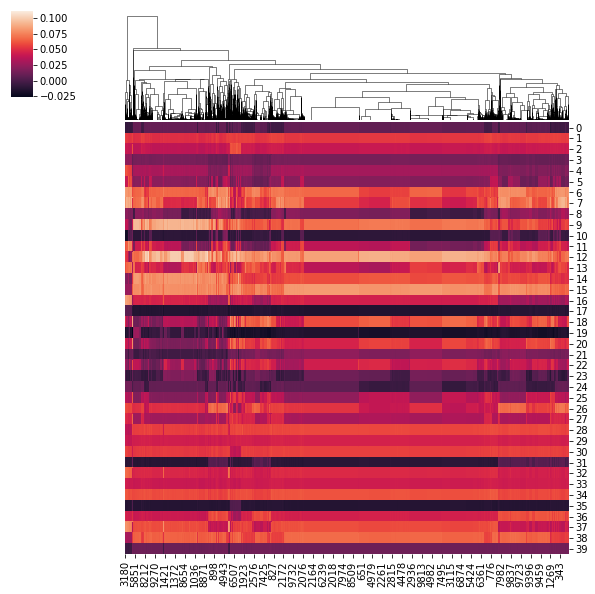

In [12]:
sns.clustermap(N.equilibria[:N.nVessels,:],row_cluster=False)

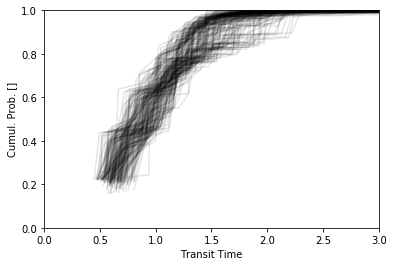

In [13]:
N.equilibria = TTDsCDFs(N).cull_equilibria()
TTDsCDFs(N).plot(alpha=0.1,xlim=3)

In [ ]:
TTDsCDFs(N).check_ttds()

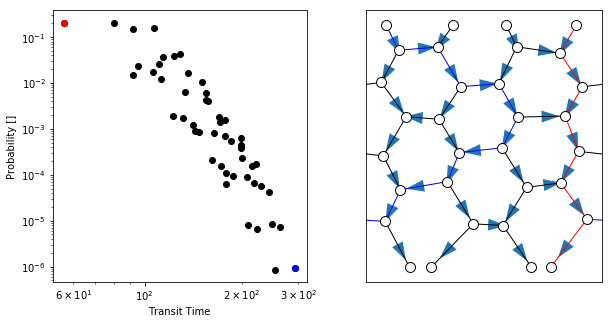

In [21]:
TTDWithPaths(N).plot(1)